# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv("/datasets/autos.csv")

In [3]:
display(df.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
def mis_inf(data): # функция для подсчета пропусков и их процента по признакам и в общем,дубликатов и размера.
    total = data.isna().sum().sort_values(ascending = False)
    percent = (data.isna().sum()/data.isna().count()*100).sort_values(ascending = False)
    print(f'Размер датафрейма:',  data.shape)
    print(f'Количество дубликатов датафрейма:', data.duplicated().sum())
    print(f'Количество пропусков датафрейма:',  total.sum())
    print(f'Процент пропусков датафрейма:',  round(percent.sum(),2))
    return pd.concat([total, round(percent,2)], axis=1, keys=['Total', 'Percent'])

In [6]:
mis_inf(df)

Размер датафрейма: (354369, 16)
Количество дубликатов датафрейма: 4
Количество пропусков датафрейма: 181077
Процент пропусков датафрейма: 51.1


,Total,Percent
Repaired,71154,20.08
VehicleType,37490,10.58
FuelType,32895,9.28
Gearbox,19833,5.60
Model,19705,5.56
DateCrawled,0,0.00
Price,0,0.00
RegistrationYear,0,0.00
Power,0,0.00
Kilometer,0,0.00


- С типами в целом, всё в порядке
- Есть много пропущенный значений
- Есть дубликаты

Удаляем дубликаты

In [7]:
df.drop_duplicates(inplace=True)


In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть явные выбросы в числовых признаках в обе стороны, которые посмотрим детально и исправим далее:
- лошадинные силы (0 и 20000?)
- год регистрации (1000 и 9999?)
- Нулевой месяц регистрации
- Нулевая цена некоторых авто


Удаляем лишние не информативные для нашей задачи признаки, которые скорее всего будут влиять на скорость продажи авто, а не его цену.

In [9]:
df.drop(['LastSeen','PostalCode','NumberOfPictures','DateCreated','DateCrawled'], axis= 1 , inplace= True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Удалил данные с неизвестными моделями, так как это основопологающий фактор, который на прямую воздействует на образование цены и заменить неизвестно что на такое же неизвестно что в этом случае неверно.

In [11]:
df.dropna(subset=['Model'], inplace=True)

Пропуски в типе кузова,типе топлива авто и типе коробки передач заменил на "Unknown"

In [12]:
columns_for_fill = ['VehicleType','FuelType','Gearbox']
df[columns_for_fill] = df[columns_for_fill].fillna('unknown')

In [13]:
print(sorted(df.RegistrationYear.unique()))

[1000, 1001, 1111, 1200, 1234, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1919, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1941, 1942, 1943, 1945, 1947, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2290, 2500, 2900, 3000, 3700, 4000, 4500, 5000, 5555, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8500, 9000, 9999]


Уникальные значения года регистрации показываю нереальные года, например начала прошлого тысячелетия и тп. Оставляем в датасете записи с годом регистрации с 1950 по 2019.

In [14]:
df=df.query('RegistrationYear >= 1950 & RegistrationYear <= 2019')

Пропуски в признаке "Repaired" заменим на "no", если год регистрации больще 2016 года, в остальных случаях будем полагать, что после гарантийного обслуживания, обычно 3 года, автомобиль был в ремонте и в таком случае пропуски заменим на "yes"

In [15]:
display(df[df['Repaired'].isna()])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,NaN
12,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...,...
354346,2600,unknown,2005,auto,0,c_klasse,150000,9,unknown,mercedes_benz,NaN
354349,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN
354356,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN
354357,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN


In [16]:
def encode(row):
    if row['RegistrationYear'] <= 2016 and pd.isna(row['Repaired']):
        return 'yes'
    else:
        return 'no'
df['Repaired'] = df.apply(encode,axis=1)


Проверяем, как функция сделала обработку

In [17]:
display(df.head(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,no
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,yes
9,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,yes
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no


In [18]:
df.Power.describe()

count    334476.000000
mean        111.365153
std         184.857614
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Гладя на уникальные значения мощности авто, наблюдаем множественные выбросы, как например, нереальные мощности автомобиля 0 и 20000.

In [19]:
print(sorted(df.Power.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

В датасете оставляем только авто с можностью от 15ти до 2500 лошадиных сил  

In [20]:
df=df.query('Power > 15 & Power < 2500')

In [21]:
print(sorted(df.Power.unique()))

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232

С пробегом автомобилей вроде все в порядке.

In [22]:
df.Kilometer.describe()

count    300452.000000
mean     128547.987699
std       36575.379519
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Визуализируем целевой признак исследования - цену. На гистограмме и в уникальных значениях видим наличие каких-то нулевых и супер низких цен, которые явно не прибавят точности нашим моделям.

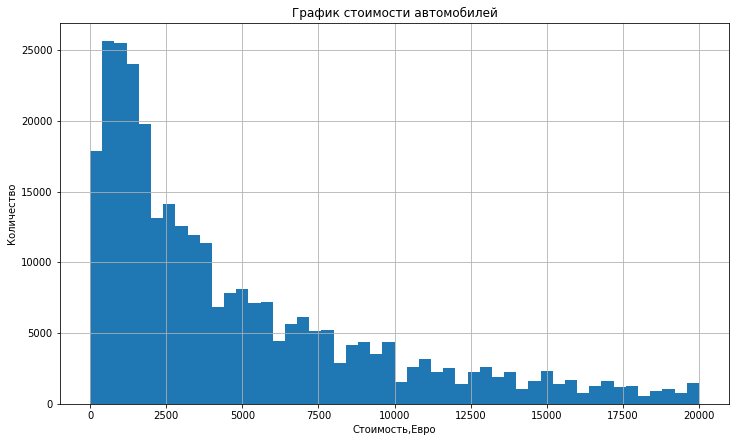

count    300452.000000
mean       4759.206362
std        4599.640571
min           0.000000
25%        1290.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64

In [23]:
df.Price.describe()
df.Price.hist(bins=50,figsize=(12,7))
plt.title('График стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()
df.Price.describe()

In [24]:
print(sorted(df.Price.unique()))

[0, 1, 2, 3, 5, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 24, 25, 26, 29, 30, 35, 38, 39, 40, 45, 47, 49, 50, 55, 60, 65, 66, 69, 70, 75, 77, 79, 80, 85, 89, 90, 95, 98, 99, 100, 101, 105, 108, 110, 111, 112, 115, 117, 119, 120, 122, 123, 125, 126, 128, 129, 130, 132, 133, 135, 139, 140, 142, 145, 149, 150, 155, 156, 157, 159, 160, 162, 165, 166, 169, 170, 173, 175, 179, 180, 181, 185, 188, 189, 190, 192, 193, 195, 196, 198, 199, 200, 202, 205, 209, 210, 211, 215, 217, 219, 220, 222, 224, 225, 229, 230, 235, 236, 240, 243, 245, 248, 249, 250, 251, 252, 253, 255, 259, 260, 261, 263, 265, 266, 269, 270, 272, 273, 274, 275, 277, 278, 279, 280, 281, 284, 285, 289, 290, 295, 298, 299, 300, 301, 305, 308, 309, 310, 315, 316, 319, 320, 321, 323, 325, 329, 330, 331, 332, 333, 335, 338, 339, 340, 341, 344, 345, 348, 349, 350, 355, 356, 359, 360, 365, 366, 369, 370, 373, 375, 377, 378, 379, 380, 384, 385, 388, 390, 393, 395, 397, 398, 399, 400, 408, 410, 414, 415, 418, 420, 422, 425, 429, 430, 433,

Оставляем в датасете только автомобили с ценами больше 50 евро. 5971 строк с ценами ниже пришлось удалить. 

In [25]:
df.query('Price < 50').value_counts()

Price  VehicleType  RegistrationYear  Gearbox  Power  Model    Kilometer  RegistrationMonth  FuelType  Brand          Repaired
0      sedan        1997              manual   75     golf     150000     0                  petrol    volkswagen     no          56
       small        2012              manual   90     rio      90000      7                  gasoline  kia            no          18
       sedan        1998              manual   60     golf     150000     0                  petrol    volkswagen     no          18
       bus          2005              manual   101    vivaro   80000      8                  gasoline  opel           no          16
       other        2002              manual   64     other    150000     2                  gasoline  seat           no           9
                                                                                                                                  ..
       sedan        2011              manual   116    i_reihe  90000      9

In [26]:
df = df.query('Price > 50')

In [27]:
df.Price.describe()

count    293624.000000
mean       4869.844934
std        4594.566280
min          55.000000
25%        1375.000000
50%        3200.000000
75%        6999.000000
max       20000.000000
Name: Price, dtype: float64

в 16540 строках месяц регистрации авто равен 0. На первый взгляд признак вроде незначительный, но был оставлен, так как вполне может влиять на цену, так как, например,не вдаваясь в подробности, авто регистрации 12.2021 будет смотреться на год старше, чем авто 01.2022

In [28]:
df.RegistrationMonth.unique()

array([ 8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  5,  9])

In [29]:
df.query('RegistrationMonth == 0').value_counts()

Price  VehicleType  RegistrationYear  Gearbox  Power  Model    Kilometer  RegistrationMonth  FuelType  Brand       Repaired
900    unknown      2017              manual   60     corsa    150000     0                  petrol    opel        no          8
1600   sedan        2001              manual   85     astra    150000     0                  petrol    opel        yes         8
950    sedan        1995              manual   115    5er      150000     0                  petrol    bmw         yes         6
1200   unknown      2017              manual   125    a4       150000     0                  petrol    audi        no          5
200    small        1996              manual   60     corsa    150000     0                  petrol    opel        no          5
                                                                                                                              ..
800    unknown      2017              manual   88     3_reihe  150000     0                  unknown  

Заполнил нулевой месяц регистрации авто средним значением 6.

In [30]:
df.loc[df['RegistrationMonth'] == 0,'RegistrationMonth'] =6

In [31]:
df.query('RegistrationMonth == 0').value_counts()

Series([], dtype: int64)

In [32]:
df = df.reset_index()

Финалаьная проверка после предобработки.

In [33]:
mis_inf(df)

Размер датафрейма: (293624, 12)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 0
Процент пропусков датафрейма: 0.0


,Total,Percent
index,0,0.0
Price,0,0.0
VehicleType,0,0.0
RegistrationYear,0,0.0
Gearbox,0,0.0
Power,0,0.0
Model,0,0.0
Kilometer,0,0.0
RegistrationMonth,0,0.0
FuelType,0,0.0


Посмотрим корреляцию целевого и остальных числовых признаков  

In [34]:
def corr_mtrx(data):      
    plt.figure(figsize=(15,10))
    sns.set(font_scale=1.4)
    corr = round(data.corr(),2)  
    sns.heatmap(corr, annot=True,linewidths = 0.1,cmap='summer')    
    plt.title('Тепловая карта корреляции')
    plt.show()

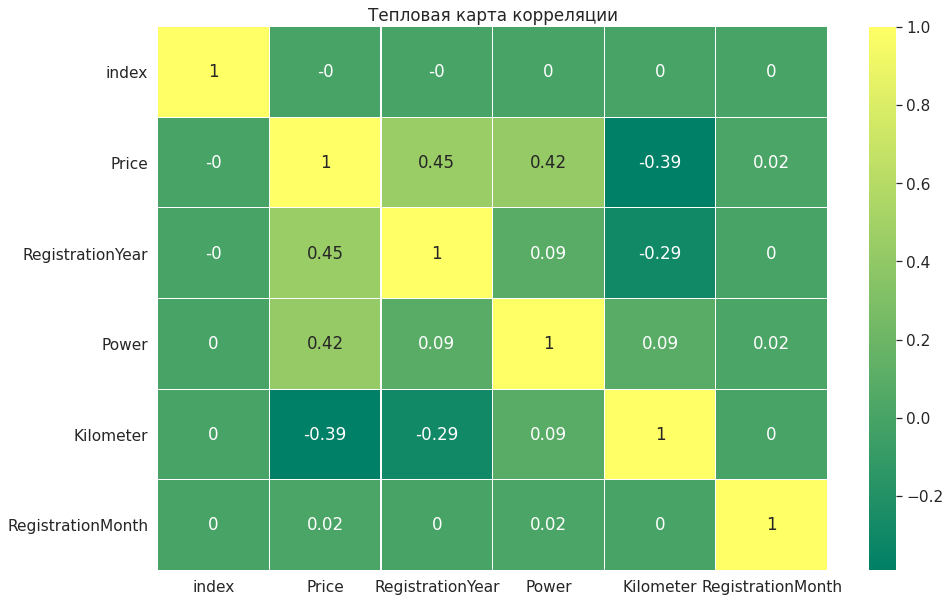

In [35]:
corr_mtrx(df)

По тепловой карте видно, что цена в положительно зависит  от года регистрации и  мощности двигателя авто (больше мощность, не так давно регистрация - цена выше), больше пробег авто - цена падает.

Итак, на этапе предобработки исходного датасета удалены дубликаты, строки с неизвестными моделями, пропуски  в признаках типа топлива, типа кузова, типа коробки передач заменены на unknown, нулевой месяц регистрации авто заменен на среднее значение  6, пропуски признака был ли автомобиль времонте заменены на yes, если автомобиль старше 3х лет. Так же удалены выбросы: в годе регистрации авто,оставлены авто с регистрацией с 1950 по 2019 год,оставлены авто с мощностью от 15 до 2500 лошадиных сил, оставлены только авто с ценой больше 50 евро.

## Обучение моделей

Разделим данные на основную выборку и целевой признак

In [36]:
features = df.drop('Price', axis=1)
target = df['Price']

In [37]:
features

,index,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes
1,3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
2,4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
3,5,sedan,1995,manual,102,3er,150000,10,petrol,bmw,no
4,6,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...,...
293619,354361,unknown,2016,auto,150,159,150000,12,unknown,alfa_romeo,no
293620,354362,sedan,2004,manual,225,leon,150000,5,petrol,seat,no
293621,354366,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
293622,354367,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [38]:
target

0         9800
1         1500
2         3600
3          650
4         2200
          ... 
293619    5250
293620    3200
293621    1199
293622    9200
293623    3400
Name: Price, Length: 293624, dtype: int64

Выбираем категориальные признаки, которые нам предствоит закодировать

Для кодирования использовал порядковое кодирование Original Encoding, т.к. буду тестировать модели основанные на деревьях - случайный лес, градиентный бустинг.

Разобьем признаки и таргет на тестовую и тренировочную выборки в пропорции 75-25, т.к. параметры мы будем искать с помощью кросс-валидации через GridSearchCV валидационная выборка нам не нужна.

In [39]:
features_train, features_test, target_train, target_test = \
    train_test_split(features,target,test_size=0.25, random_state=12345)

In [40]:
print('Тренировочная выборка- {:.0%}'.format(features_train.shape[0]/features.shape[0]))
print('Тестовая выборка - {:.0%}'.format(features_test.shape[0]/features.shape[0]))

Тренировочная выборка- 75%
Тестовая выборка - 25%


Выделяю категориальные и числовые признаки.

In [41]:
category_features=['VehicleType', 'Gearbox','Model','FuelType', 'Brand', 'Repaired']
num_features=['RegistrationYear','Power','Kilometer','RegistrationMonth']

In [42]:
encoder = OrdinalEncoder(handle_unknown='ignore')
encoder.fit(features_train[category_features])

OrdinalEncoder(handle_unknown='ignore')

In [43]:
features_train_encoded=features_train.copy()
features_train_encoded[category_features]= encoder.transform(features_train[category_features])
                                                  
features_train_encoded.head()

,index,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
89056,107594,5.0,1999,1.0,60,128.0,60000,6,7.0,10.0,0.0
126064,152221,8.0,2011,1.0,140,122.0,100000,4,6.0,24.0,1.0
74935,90608,7.0,2017,0.0,150,71.0,125000,3,2.0,14.0,0.0
155406,187668,7.0,2016,0.0,75,42.0,150000,8,7.0,24.0,1.0
197046,238023,8.0,2006,1.0,163,11.0,150000,4,2.0,2.0,0.0


In [44]:
features_test_encoded=features_test.copy()
features_test_encoded[category_features]= encoder.transform(features_test[category_features])
                                                     

features_test_encoded.head()

,index,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
177793,214735,0.0,1998,1.0,100,166.0,150000,3,6.0,25.0,0.0
155802,188150,8.0,2003,0.0,193,15.0,150000,5,2.0,2.0,0.0
195454,236107,4.0,1996,1.0,125,28.0,150000,11,6.0,1.0,0.0
74277,89833,4.0,1994,1.0,150,11.0,150000,6,6.0,2.0,1.0
34700,42067,7.0,2018,1.0,140,221.0,150000,12,6.0,37.0,0.0


Проведем масштабирование числовых признаков при помощи StandartScaler. Обучать scaler будем только на выборке train, так как иначе это может привести к утечке данных (data leak).

In [45]:
scaler = StandardScaler()

scaler.fit(features_train[num_features])
scaled_features_train_encoded=features_train_encoded.copy()
scaled_features_test_encoded=features_test_encoded.copy()

scaled_features_train_encoded[num_features] = scaler.transform(features_train_encoded[num_features])
scaled_features_test_encoded[num_features] = scaler.transform(features_test_encoded[num_features])


In [46]:
scaled_features_train_encoded

,index,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
89056,107594,5.0,-0.655459,1.0,-0.957975,128.0,-1.877571,-0.112062,7.0,10.0,0.0
126064,152221,8.0,1.139355,1.0,0.295204,122.0,-0.780882,-0.727385,6.0,24.0,1.0
74935,90608,7.0,2.036762,0.0,0.451851,71.0,-0.095452,-1.035046,2.0,14.0,0.0
155406,187668,7.0,1.887194,0.0,-0.723004,42.0,0.589979,0.503260,7.0,24.0,1.0
197046,238023,8.0,0.391516,1.0,0.655493,11.0,0.589979,-0.727385,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
158838,191827,4.0,0.391516,1.0,0.295204,233.0,-1.877571,-1.035046,6.0,24.0,0.0
47873,57953,4.0,0.241948,1.0,-0.190403,10.0,0.589979,-1.035046,2.0,19.0,0.0
86398,104374,7.0,2.186330,1.0,-0.723004,28.0,0.589979,1.118582,6.0,1.0,0.0
77285,93428,8.0,0.391516,1.0,1.517053,11.0,0.589979,-0.112062,6.0,2.0,0.0


In [47]:
scaled_features_test_encoded

,index,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
177793,214735,0.0,-0.805027,1.0,-0.331386,166.0,0.589979,-1.035046,6.0,25.0,0.0
155802,188150,8.0,-0.057188,0.0,1.125435,15.0,0.589979,-0.419723,2.0,2.0,0.0
195454,236107,4.0,-1.104163,1.0,0.060233,28.0,0.589979,1.426244,6.0,1.0,0.0
74277,89833,4.0,-1.403298,1.0,0.451851,11.0,0.589979,-0.112062,6.0,2.0,1.0
34700,42067,7.0,2.186330,1.0,0.295204,221.0,0.589979,1.733905,6.0,37.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
283448,342085,5.0,0.690652,1.0,-0.707340,226.0,0.589979,0.810921,6.0,27.0,1.0
195787,236498,0.0,0.092380,1.0,-0.488033,50.0,-1.055055,-1.035046,2.0,5.0,0.0
201823,243750,5.0,-0.505891,1.0,-0.973640,176.0,0.589979,-1.650368,6.0,9.0,0.0
204219,246624,5.0,0.840219,1.0,-0.456704,215.0,-1.329227,1.118582,6.0,34.0,1.0


По условиям проекта, для оценки качества моделей применять метрику RMSE. Значение метрики RMSE должно быть меньше 2500. 
Среднеквадратичная ошибка (RMSE) оценивает качество работы модели регрессии. Эти показатели говорят нам, насколько точны наши прогнозы и какова величина отклонения от фактических значений.Создадим функцию для определения RMSE.

In [48]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

Тестировать буду 3 модели RandomForest, CatBoostRegressor и LightGBM

### **RandomForest**

Обучаем модель и вычисляем время обучения. Среди гиперпараметров будем искать наилучщую глубину и количество деревьев.

In [49]:
RFR = RandomForestRegressor(bootstrap=True,random_state=12345)

parameters = {'max_depth': [x for x in range (3,13,3)],
              'n_estimators': [x for x in range(100,151,50)],
             }

grid_RFR = GridSearchCV(RFR,parameters,cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1,verbose=25)
grid_RFR = grid_RFR.fit(scaled_features_train_encoded,target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START max_depth=3, n_estimators=100...............................
[CV 1/3; 1/8] END .............max_depth=3, n_estimators=100; total time=  12.5s
[CV 2/3; 1/8] START max_depth=3, n_estimators=100...............................
[CV 2/3; 1/8] END .............max_depth=3, n_estimators=100; total time=  12.3s
[CV 3/3; 1/8] START max_depth=3, n_estimators=100...............................
[CV 3/3; 1/8] END .............max_depth=3, n_estimators=100; total time=  11.8s
[CV 1/3; 2/8] START max_depth=3, n_estimators=150...............................
[CV 1/3; 2/8] END .............max_depth=3, n_estimators=150; total time=  17.9s
[CV 2/3; 2/8] START max_depth=3, n_estimators=150...............................
[CV 2/3; 2/8] END .............max_depth=3, n_estimators=150; total time=  18.6s
[CV 3/3; 2/8] START max_depth=3, n_estimators=150...............................
[CV 3/3; 2/8] END .............max_depth=3, n_est

Посмотрим, как выглядит датафрейм с результатами.

In [50]:
pd.DataFrame(grid_RFR.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,11.976077,0.312365,0.198018,0.001828,3,100,"{'max_depth': 3, 'n_estimators': 100}",-2951.865698,-2954.324748,-2930.822181,-2945.670876,10.547497,7
1,18.062563,0.309093,0.309275,0.008773,3,150,"{'max_depth': 3, 'n_estimators': 150}",-2954.077942,-2953.812331,-2930.593634,-2946.161303,11.008538,8
2,22.491654,0.563115,0.342703,0.012294,6,100,"{'max_depth': 6, 'n_estimators': 100}",-2275.069685,-2259.679955,-2239.348904,-2258.032848,14.629383,5
3,32.799594,0.590139,0.511412,0.018324,6,150,"{'max_depth': 6, 'n_estimators': 150}",-2276.646576,-2260.946124,-2238.654681,-2258.749127,15.587733,6
4,30.250857,0.144178,0.563435,0.013113,9,100,"{'max_depth': 9, 'n_estimators': 100}",-1977.994254,-1952.939052,-1942.574574,-1957.835960,14.868831,3
5,46.024042,0.156067,0.861516,0.022733,9,150,"{'max_depth': 9, 'n_estimators': 150}",-1978.331212,-1953.028659,-1942.228130,-1957.862667,15.130188,4
6,38.192263,0.112237,0.909967,0.003255,12,100,"{'max_depth': 12, 'n_estimators': 100}",-1788.772797,-1769.453439,-1755.975736,-1771.400657,13.459954,2
7,55.971450,1.154873,1.395210,0.081797,12,150,"{'max_depth': 12, 'n_estimators': 150}",-1788.317107,-1769.617133,-1755.037684,-1770.990641,13.620937,1


In [51]:
results_df=pd.DataFrame()

In [52]:
def results(model):
    global results_df
    # лучшее значение RMSE на кросс-валидации
    best_score=model.best_score_*-1
    print(f'best_score RMSE: {round(best_score,2)}')
    
   
   
    # лучшие гиперпараметры
    print(f'best_params: {model.best_params_}')
    best_params_index=model.cv_results_['params'].index(model.best_params_)
    best_fit_time = round(model.cv_results_['mean_fit_time'][best_params_index],2)
    best_score_time = round(model.cv_results_['mean_score_time'][best_params_index],2)
   
    print('best fit time, sec.:',best_fit_time)
    print('best score time, sec.:',best_score_time)
    
    estimator=model.estimator.__class__.__name__
    model_result=pd.DataFrame({'Model':[estimator],'RMSE':[best_score],'Fit_Time':[best_fit_time],'Score_time':[best_score_time]})
    results_df=pd.concat([results_df,model_result],ignore_index=True)
    
    return results_df
    

In [53]:
results(grid_RFR)

best_score RMSE: 1770.99
best_params: {'max_depth': 12, 'n_estimators': 150}
best fit time, sec.: 55.97
best score time, sec.: 1.4


,Model,RMSE,Fit_Time,Score_time
0,RandomForestRegressor,1770.990641,55.97,1.4


### **CatBoostRegressor**

В модели CatBoost реализован  внутренний метод кодировки данных. Т.е. модель CatBoost работает с категориальными признаками, и не требует их перевода в числа. Поэтому придется снова разбить датасет на выборки без кодирования и отмасштабировать их.

Берем некодированные выборки и масштабируем числовые признаки

In [54]:
scaler.fit(features_train[num_features])
features_train_CBR=features_train.copy()
features_test_CBR=features_test.copy()
features_train_CBR[num_features] = scaler.transform(features_train_CBR[num_features])
features_test_CBR[num_features] = scaler.transform(features_test_CBR[num_features])

Обучаем модель и вычисляем время обучения и предсказания.

In [55]:
CBR = CatBoostRegressor(loss_function='RMSE',silent=True, cat_features=category_features, random_seed=12345)
CBR_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 61, 20),'depth': range(3,13,3)}

grid_CBR = GridSearchCV(CBR, CBR_params, cv=3, scoring='neg_root_mean_squared_error',n_jobs = -1, verbose = 25)
grid_CBR.fit(features_train_CBR, target_train);

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3; 1/60] START depth=3, iterations=20, learning_rate=0.001................
[CV 1/3; 1/60] END depth=3, iterations=20, learning_rate=0.001; total time=   1.8s
[CV 2/3; 1/60] START depth=3, iterations=20, learning_rate=0.001................
[CV 2/3; 1/60] END depth=3, iterations=20, learning_rate=0.001; total time=   1.7s
[CV 3/3; 1/60] START depth=3, iterations=20, learning_rate=0.001................
[CV 3/3; 1/60] END depth=3, iterations=20, learning_rate=0.001; total time=   1.6s
[CV 1/3; 2/60] START depth=3, iterations=20, learning_rate=0.005623413251903491.
[CV 1/3; 2/60] END depth=3, iterations=20, learning_rate=0.005623413251903491; total time=   1.7s
[CV 2/3; 2/60] START depth=3, iterations=20, learning_rate=0.005623413251903491.
[CV 2/3; 2/60] END depth=3, iterations=20, learning_rate=0.005623413251903491; total time=   1.7s
[CV 3/3; 2/60] START depth=3, iterations=20, learning_rate=0.005623413251903491.
[CV 3/3

In [56]:
results(grid_CBR)

best_score RMSE: 1685.57
best_params: {'depth': 12, 'iterations': 60, 'learning_rate': 0.1778279410038923}
best fit time, sec.: 10.47
best score time, sec.: 0.13


,Model,RMSE,Fit_Time,Score_time
0,RandomForestRegressor,1770.990641,55.97,1.40
1,CatBoostRegressor,1685.566194,10.47,0.13


### **LightGBM**

Обучаем модель и вычисляем время обучения и предсказания.

In [57]:
features_train_CBR[category_features]=features_train_CBR[category_features].astype('category')
features_test_CBR[category_features]=features_test_CBR[category_features].astype('category')
features_train_CBR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220218 entries, 89056 to 217570
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   index              220218 non-null  int64   
 1   VehicleType        220218 non-null  category
 2   RegistrationYear   220218 non-null  float64 
 3   Gearbox            220218 non-null  category
 4   Power              220218 non-null  float64 
 5   Model              220218 non-null  category
 6   Kilometer          220218 non-null  float64 
 7   RegistrationMonth  220218 non-null  float64 
 8   FuelType           220218 non-null  category
 9   Brand              220218 non-null  category
 10  Repaired           220218 non-null  category
dtypes: category(6), float64(4), int64(1)
memory usage: 11.6 MB


In [58]:
LGBM = LGBMRegressor(boosting_type='gbdt',random_state=12345, learning_rate = 0.18, objective='rmse',force_col_wise=True)
LGBM_params ={'n_estimators': [40, 60], 'num_leaves': [31, 41, 51]}
grid_LGBM = GridSearchCV(LGBM, LGBM_params, cv=3, scoring='neg_root_mean_squared_error', verbose = 25)
grid_LGBM.fit(features_train_CBR, target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START n_estimators=40, num_leaves=31..............................
[CV 1/3; 1/6] END ............n_estimators=40, num_leaves=31; total time=   4.3s
[CV 2/3; 1/6] START n_estimators=40, num_leaves=31..............................
[CV 2/3; 1/6] END ............n_estimators=40, num_leaves=31; total time=   5.0s
[CV 3/3; 1/6] START n_estimators=40, num_leaves=31..............................
[CV 3/3; 1/6] END ............n_estimators=40, num_leaves=31; total time=   5.2s
[CV 1/3; 2/6] START n_estimators=40, num_leaves=41..............................
[CV 1/3; 2/6] END ............n_estimators=40, num_leaves=41; total time=   5.5s
[CV 2/3; 2/6] START n_estimators=40, num_leaves=41..............................
[CV 2/3; 2/6] END ............n_estimators=40, num_leaves=41; total time=   5.7s
[CV 3/3; 2/6] START n_estimators=40, num_leaves=41..............................
[CV 3/3; 2/6] END ............n_estimators=40, nu

GridSearchCV(cv=3,
             estimator=LGBMRegressor(force_col_wise=True, learning_rate=0.18,
                                     objective='rmse', random_state=12345),
             param_grid={'n_estimators': [40, 60], 'num_leaves': [31, 41, 51]},
             scoring='neg_root_mean_squared_error', verbose=25)

In [59]:
results(grid_LGBM)

best_score RMSE: 1638.43
best_params: {'n_estimators': 60, 'num_leaves': 51}
best fit time, sec.: 25.3
best score time, sec.: 0.54


,Model,RMSE,Fit_Time,Score_time
0,RandomForestRegressor,1770.990641,55.97,1.40
1,CatBoostRegressor,1685.566194,10.47,0.13
2,LGBMRegressor,1638.430788,25.30,0.54


## Анализ моделей

Посмотрим какие признаки модели выбирают, как наиболее важные для предсказаний.Для этого создал процедуру для визуализации важности признаков.

In [60]:
def importance(model,features):
    features=features.columns
    importances = model.best_estimator_.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(8, 5))
    plt.title(f'Важность признаков модели {model.estimator.__class__.__name__}')
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()    

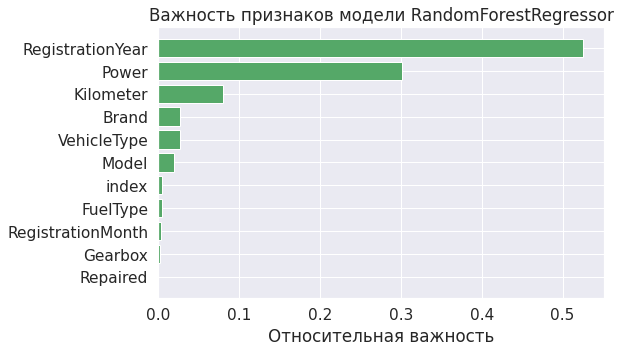

In [61]:
importance(grid_RFR,scaled_features_train_encoded)

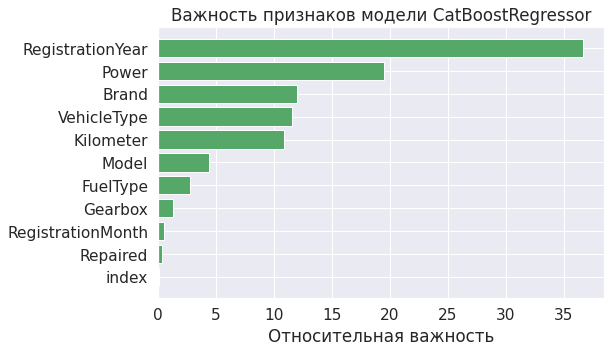

In [62]:
importance(grid_CBR,features_train_CBR)

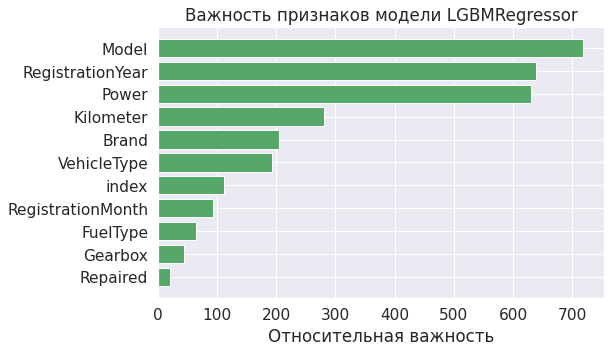

In [63]:
importance(grid_LGBM,features_train_CBR)

Приведённые выше графики показывают, что на выбранных данных модели RandomForest и CatBoost ведут себя схожим образом и отбирают почти одни и те же наиболее важные по весу признаки год регистрации и мощность авто, у модели LightGBM наиболее важный признак, влияющий на предсказание цены, это модель авто, а потом уже год регистрации,мощность и прочие признаки.

Исходя из условий задачи, нам важны:
1. качество предсказания; 
2. скорость предсказания; 
3. время обучения.

**Исходя из результатов, по качеству предсказания и времени обучения лидирует модель LGBMRegressor, ее и будет финально тестировать на тестовой выборке.**

In [64]:
predict_LGBM = grid_LGBM.best_estimator_.predict(features_test_CBR)

In [65]:
print('RMSE',rmse(target_test,predict_LGBM))

RMSE 1639.14


**ВЫВОД: Модель LightGBM так же качественно предсказывает на тестовой выбоке как и на тренировочной.**  

## Вывод

Для выполнения поставленной задачи были обучены модели RandomForest,CatBoost и LightGMB. Исходный датасет был предобработан с целью избавиться от пропусков и выбросов данных. Для каждой модели подготовлены входные данные. Для модели CatBoost и  LightGBM данные без кодирования, так как в этих моделях реализован механизм самостоятельной обработки категориальных признаков, на входе RandomForest данные преобразованы методом Original Encoding.Все данные были отмасштабированы.

 - Наилучшие параметры из ряда предложенных для RandomForest n_estimators=150, depth=12. RMSE по данным параметрам best_score      RMSE: 1770.99, из    трех моделей это наихудший результат. Время обучения best fit time, sec.: 52.38 это худший результат.      Время предсказания best score time, sec.: 1.23 это худший результат.
 
 - Наилучшие параметры из ряда предложенных для CatBoostRegressor 'depth': 12, 'iterations': 60, 'learning_rate':                  0.1778279410038923. RMSE по данным параметрам best_score RMSE: 1685.57. Время обучения best fit time, sec.: 9.57. Время        прогноза наилучшее из трех моделей best score time, sec.: 0.11.

 - Наилучшие параметры из ряда предложенных для LightGBM best_params: {'n_estimators': 60, 'num_leaves': 51}
   В результате RMSE по данным параметрам best_score **RMSE: 1638.43 это лучший по качеству результат**
   best fit time, sec.: 4.16 **лучший результат**
   best score time, sec.: 0.5 

Исходя из результатов, предпочтение дыло отдано модели **LightGBM**, т.к. она имеет лучшее качество, скорость обучения в данной задаче. Предсказание данной модели на тестовой выборке не изменилось по качеству с показателем RMSE 1639.14/